# Input Models


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time
import numpy as np

import tensorflow as tf
import os
import matplotlib.pyplot as plt
from matplotlib import cm 

import torch
import torch.optim as optim
from torch import nn

from spaces import FinitePowerSeries, FiniteChebyshev, GRF
from system import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem

from scipy.fft import fft, ifft, fftfreq
from scipy.linalg import dft
import scipy
from utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test
import schrodinger_system
import schrodinger_nonlinear_system
import time
from schrodinger_system import plot_schrodinger_2d, plot_schrodinger_3d, plot_schrodinger_prob, plot_schrodinger_energy

#from schrodinger_system import gen_schro_dataset_fixed, gen_schro_dataset_sigma, gen_schro_dataset_x0, gen_schro_dataset_fixed_real
#from models import model, model_matrix_batch



def model_matrix_batch(X, net): # take in num_datax1
    x_func = net.branch(torch.tensor(X[0])) # output num_datax 2x2, num_datax 4
    
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1])))

    x_func = x_func.view(x_func.shape[0], 2, -1).to(torch.float64)
    x_loc = x_loc.unsqueeze(2).to(torch.float64)
    
    #b =  torch.tensor([net.b[0], net.b[1]], dtype=torch.float64).unsqueeze(1)
    #b_batch = b.expand(x_func.shape[0], -1, -1).to(torch.float64)
    
    result = torch.bmm(x_func, x_loc).to(torch.float64) #+ b_batch
    #print(f"result: {result.shape}")
    return result.squeeze()

def model_schro(X, net):
    x_func = torch.tensor(X[0], dtype=torch.complex64)
    x_func = net.branch(x_func).to(torch.complex64) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex64).squeeze(0)
    #x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex64)
    x_loc = x_loc.unsqueeze(2).to(torch.complex64)
    
    result = torch.bmm(x_func, x_loc).to(torch.complex64) 
    #result  = torch.einsum('bij,kj->bik', x_func, x_loc)
    #result = torch.einsum('bi, bi->b', x_func, x_loc).to(torch.complex64)
    #result = net.concatenate_outputs(xs)
    #print(f"result = {result}")
    return result

def model_schro_multi(X, net):
    x_func = torch.tensor(X[0], dtype=torch.complex64)
    x_func = net.branch(x_func).to(torch.complex64) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex64).squeeze(0)
    #x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex64)
    x_loc = torch.transpose(x_loc, 0, 1)
    
    result = torch.matmul(x_func, x_loc).to(torch.complex64) 
    #result  = torch.einsum('bij,kj->bik', x_func, x_loc)
    #result = torch.einsum('bi, bi->b', x_func, x_loc).to(torch.complex64)
    #result = net.concatenate_outputs(xs)
    #print(f"result = {result}")
    return result.permute(0, 2, 1).squeeze()

def model_schro_prob_simple(X, net, x_max = 10, fourier =True):
    # Apply branch and trunk network
    x_func = torch.tensor(X[0], dtype=torch.complex64)
    x_func = net.branch(x_func).to(torch.complex64) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex64).squeeze(0)
    #x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex64)
    x_loc = x_loc.unsqueeze(2).to(torch.complex64)
    
    # Probability preservation on
    nx = X[0].shape[1]
    dx = x_max / nx
    
    #E = nx / dx if fourier else 1 /dx
    E = torch.tensor([torch.sum(torch.abs(torch.abs(Xi)**2)) for Xi in torch.tensor(X[0], dtype=torch.complex64)])
    
    
    Q, R = torch.linalg.qr(x_func)
    alpha_tilde = torch.matmul(R, x_loc).to(torch.complex64)
    
    norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True)
    #alpha_scaled = alpha_tilde* np.sqrt(E) / norm_alpha_tilde
    alpha_scaled = alpha_tilde* torch.sqrt(E).unsqueeze(1).unsqueeze(2) / norm_alpha_tilde
    
    result_prob = torch.bmm(Q, alpha_scaled).to(torch.complex64)
    
    
    return result_prob.squeeze()


def model_schro_structure_simple(X, net, x_max = 10, potential="zero"):
    """ DeepoNet model for Schrodinger's equation with energy and probability preservation
    """
    # Apply branch and trunk network
    global keep_energy
    global keep_prob
    x_func = torch.tensor(X[0], dtype=torch.complex64)
    x_func = net.branch(x_func).to(torch.complex64) 
    
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex64).squeeze(0)
    x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex64)
    
    result = torch.bmm(x_func, x_loc).to(torch.complex64)
    u_hat_init = torch.tensor(X[0], dtype=torch.complex64)
    
    if keep_energy:
        nx = X[0].shape[1] 
        dx = x_max / (nx - 1)
        
        # DFT matrix W
        W_np = dft(nx)
        W = torch.tensor(W_np, dtype=torch.complex64)
        W_inv_np = W_np.conj().T / nx
        W_inv = torch.tensor(W_inv_np, dtype=torch.complex64).contiguous()
        
        # Differentiation matrix D
        k_np = (2 * np.pi ) * fftfreq(nx, dx)
        k = torch.tensor(k_np, dtype=torch.complex64)
        D = torch.diag(1j * k)
        
        # Define relvant matrices
        
   
        #theta = D_large.conj().T@W_large_inv.conj().T@omega@W_large_inv@D_large
        theta = (torch.eye(nx, dtype=torch.complex64) + D.conj().T@D) / (4 * nx)
        theta_sqrt = torch.diag(torch.sqrt(torch.diagonal(theta)))
        theta_sqrt_inv = torch.diag(1 / torch.diagonal(theta_sqrt))
        
        init_ux_sol = u_hat_init@D.T@W_inv.T
        init_u_sol = u_hat_init@W_inv.T
    
        # Caulate energy
        E = (
        torch.sum(0.25 * (torch.abs(init_ux_sol)**2), dim=1) + 0.25 *
        torch.sum(torch.abs(init_u_sol)**2, dim=1)).to(torch.complex64)
        
        B_tilde = torch.einsum("pn, mnl ->mpl", theta_sqrt, x_func)
        
        Q_tilde, R = torch.linalg.qr(B_tilde)
        
        alpha_tilde = torch.matmul(R, x_loc).to(torch.complex64)
        
        norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True)
        # Create a mask for zero values
        zero_mask = (norm_alpha_tilde == 0)

        # Replace zeros with ones in the denominator to avoid division by zero
        safe_norm = torch.where(zero_mask, torch.ones_like(norm_alpha_tilde), norm_alpha_tilde)
        #alpha_scaled = alpha_tilde* np.sqrt(E) / norm_alpha_tilde
        p = alpha_tilde.shape[1]
        alpha_scaled = alpha_tilde* torch.sqrt(E).unsqueeze(1).unsqueeze(2) / safe_norm
        
        result_energy = torch.bmm(theta_sqrt_inv@Q_tilde, alpha_scaled).to(torch.complex64).squeeze()
        result = result_energy.clone()
    
    if keep_prob:
        norm_init = torch.norm(u_hat_init, dim=1, keepdim=True) 
        norm_result = torch.norm(result, dim=1, keepdim=True)
        
        norm_result_safe = norm_result.clone()
        norm_result_safe[norm_result_safe == 0] = 1.0
        
        result_scaled = result * (norm_init / norm_result_safe)
        
        result = result_scaled.clone()
    
    return result.squeeze()

def model_schro_structure_multi(X, net, x_max = 10, potential="zero", fourier =True, keep_energy=False, keep_prob=False):
    """ DeepoNet model for Schrodinger's equation with energy and probability preservation
    """
    # Apply branch and trunk network
    #global keep_energy
    #global keep_prob
    x_func = torch.tensor(X[0], dtype=torch.complex64)
    x_func = net.branch(x_func).to(torch.complex64) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex64).squeeze(0)
    #x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex64)
    x_loc = torch.transpose(x_loc, 0, 1)
    
    result = torch.matmul(x_func, x_loc).to(torch.complex64) 
    u_hat_init = torch.tensor(X[0], dtype=torch.complex64)
    
    if keep_energy:
        nx = X[0].shape[1] 
        dx = x_max / (nx - 1)
        
        # DFT matrix W
        W_np = dft(nx)
        W = torch.tensor(W_np, dtype=torch.complex64)
        W_inv_np = W_np.conj().T / nx
        W_inv = torch.tensor(W_inv_np, dtype=torch.complex64).contiguous()
        
        # Differentiation matrix D
        k_np = (2 * np.pi ) * fftfreq(nx, dx)
        k = torch.tensor(k_np, dtype=torch.complex64)
        D = torch.diag(1j * k)
        
        # Define relvant matrices
        
   
        #theta = D_large.conj().T@W_large_inv.conj().T@omega@W_large_inv@D_large
        theta = (torch.eye(nx, dtype=torch.complex64) + D.conj().T@D) / (4 * nx)
        theta_sqrt = torch.diag(torch.sqrt(torch.diagonal(theta)))
        theta_sqrt_inv = torch.diag(1 / torch.diagonal(theta_sqrt))
        
        init_ux_sol = u_hat_init@D.T@W_inv.T
        init_u_sol = u_hat_init@W_inv.T
    
        # Caulate energy
        E = (
        torch.sum(0.25 * (torch.abs(init_ux_sol)**2), dim=1) + 0.25 *
        torch.sum(torch.abs(init_u_sol)**2, dim=1)).to(torch.complex64)
        
        B_tilde = torch.einsum("pn, mnl ->mpl", theta_sqrt, x_func)
        
        Q_tilde, R = torch.linalg.qr(B_tilde)
        
        alpha_tilde = torch.matmul(R, x_loc).to(torch.complex64)
        
        norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True)
        # Create a mask for zero values
        zero_mask = (norm_alpha_tilde == 0)

        # Replace zeros with ones in the denominator to avoid division by zero
        safe_norm = torch.where(zero_mask, torch.ones_like(norm_alpha_tilde), norm_alpha_tilde)
        #alpha_scaled = alpha_tilde* np.sqrt(E) / norm_alpha_tilde
        p = alpha_tilde.shape[1]
        alpha_scaled = alpha_tilde* torch.sqrt(E).unsqueeze(1).unsqueeze(2) / safe_norm
        
        result_energy = torch.bmm(theta_sqrt_inv@Q_tilde, alpha_scaled).to(torch.complex64).squeeze()
        result = result_energy.clone()
    
    if keep_prob:
        norm_init = torch.norm(u_hat_init, dim=1, keepdim=True) 
        norm_result = torch.norm(result, dim=1, keepdim=True)
        
        norm_result_safe = norm_result.clone()
        norm_result_safe[norm_result_safe == 0] = 1.0
        
        result_scaled = result * norm_init.unsqueeze(1) / norm_result_safe
        
        result = result_scaled.clone()
    
    return result.permute(0, 2, 1).squeeze()

def model_schro_prob_multi(X, net, x_max = 10, fourier =True):
    # Apply branch and trunk network
    x_func = torch.tensor(X[0], dtype=torch.complex64)
    x_func = net.branch(x_func).to(torch.complex64) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex64)
    #x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex64)
    x_loc = torch.transpose(x_loc, 0, 1)
    
    # Probability preservation on
    nx = X[0].shape[1]
    dx = x_max / nx
    
    E = nx / dx if fourier else 1 /dx
    
    Q, R = torch.linalg.qr(x_func)
    alpha_tilde = torch.matmul(R, x_loc).to(torch.complex64)
    
    norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True) + 1e-08
    alpha_scaled = alpha_tilde* np.sqrt(E) / norm_alpha_tilde
    
    result_prob = torch.bmm(Q, alpha_scaled).to(torch.complex64)
    
    
    return result_prob.permute(0, 2, 1).squeeze()


def complex_relu(x):
    return torch.relu(x.real) + 1j * torch.relu(x.imag)

def complex_mse_loss(pred, target):
    """
    Compute the MSE loss for complex-valued tensors.
    
    Parameters:
        pred (torch.Tensor): Predicted complex tensor (dtype=torch.complex64 or torch.complex64)
        target (torch.Tensor): Target complex tensor (same shape and dtype as pred)

    Returns:
        torch.Tensor: Scalar tensor (the mean squared error)
    """
    pred_real = pred.real
    pred_imag = pred.imag
    target_real = target.real
    target_imag = target.imag
    
    mse_real = torch.mean((pred_real - target_real)**2)
    mse_imag = torch.mean((pred_imag - target_imag)**2)

    # Total loss is sum of both parts
    return mse_real + mse_imag

def complex_l2_relative_error(pred, target, std=False):
    """
    Compute the L2 relative error for complex-valued tensors.

    Parameters:
        pred (torch.Tensor): Predicted complex tensor (dtype=torch.complex64 or torch.complex64)
        target (torch.Tensor): Target complex tensor (same shape and dtype as pred)

    Returns:
        torch.Tensor: Scalar tensor (the relative error)
    """
    epsilon = 1e-10
    # Compute squared magnitude difference
    num_samples = pred.shape[0]
    error = pred - target
    l2_err = torch.zeros(num_samples, dtype=torch.float64, device=target.device)
    for i in range(num_samples):
        
        error_norm = torch.sum(error[i].real**2 + error[i].imag**2)
        # Compute squared magnitude of target
        target_norm = torch.sum(target[i].real**2 + target[i].imag**2)
        # Avoid divide-by-zero (in case the target is all zeros, though this is rare)

            #return torch.tensor(float('inf'), device=target.device)
        # Relative L2 error
        if target_norm == 0:
            rel_error = 1.0 if not np.allclose(pred, 0) else 0.0
            #print(error_norm)
        else:
            rel_error = torch.sqrt(error_norm / target_norm)
            
        l2_err[i] = rel_error
    
    #print(l2_err)
    
    if std:
        return torch.mean(l2_err), torch.std(l2_err)

    return torch.mean(l2_err)

def complex_mse_loss(pred, target):
    """
    Compute the MSE loss for complex-valued tensors.
    
    Parameters:
        pred (torch.Tensor): Predicted complex tensor (dtype=torch.complex64 or torch.complex64)
        target (torch.Tensor): Target complex tensor (same shape and dtype as pred)

    Returns:
        torch.Tensor: Scalar tensor (the mean squared error)
    """
    pred_real = pred.real
    pred_imag = pred.imag
    target_real = target.real
    target_imag = target.imag
    
    mse_real = torch.mean((pred_real - target_real)**2)
    mse_imag = torch.mean((pred_imag - target_imag)**2)

    # Total loss is sum of both parts
    return mse_real + mse_imag

def schro_energy_loss(y_pred, y_true,x_max=10, potential="zero", std=False):
    """ Compute the MSE loss for Schrodinger's equation with energy and probability preservation
"""
    nx = y_pred.shape[-1] 
    nt = y_pred.shape[-2]
    dx = x_max / (nx - 1)
        
        # DFT matrix W

    W_np = dft(nx)
    W = torch.tensor(W_np, dtype=torch.complex64)
    W_inv_np = W_np.conj().T / nx
    W_inv = torch.tensor(W_inv_np, dtype=torch.complex64).contiguous()
        
        # Differentiation matrix D
    k_np = (2 * np.pi ) * fftfreq(nx, dx)
    k = torch.tensor(k_np, dtype=torch.complex64)
    D = torch.diag(1j * k)
    
    ux_sol_pred = y_pred@D.T@W_inv.T
    u_sol_pred = y_pred@W_inv.T
    
    ux_sol_true = y_true@D.T@W_inv.T
    u_sol_true = y_true@W_inv.T

    # Caulate energy
    E_pred = (
    torch.sum(0.25 * (torch.abs(ux_sol_pred)**2), dim=-1) + 0.25 *
    torch.sum(torch.abs(u_sol_pred)**2, dim=-1)).to(torch.complex64)
    
    #print(E_pred.shape)
    
    E_true = (
    torch.sum(0.25 * (torch.abs(ux_sol_true[:, 0,:])**2), dim=-1) + 0.25 *
    torch.sum(torch.abs(u_sol_true[:, 0, :])**2, dim=-1)).unsqueeze(-1).repeat(1, nt).to(torch.complex64)
    
    E_mse = torch.abs(E_pred - E_true)**2
    energy_loss = torch.mean(E_mse)
    
    if std:
        # Calculate the standard deviation of the energy loss
        energy_loss_std = torch.std(E_mse)
        return energy_loss, energy_loss_std

    # Add any additional terms if needed (e.g., regularization, etc.)
    
    return energy_loss

def schro_prob_loss(y_pred, y_true,x_max=10, potential="zero", std=False):
    """ Compute the MSE loss for Schrodinger's equation with energy and probability preservation
""" 
    nx = y_pred.shape[-1] 
    dx = x_max / (nx - 1)
        
        # DFT matrix W

    W_np = dft(nx)
    W = torch.tensor(W_np, dtype=torch.complex64)
    W_inv_np = W_np.conj().T / nx
    W_inv = torch.tensor(W_inv_np, dtype=torch.complex64).contiguous()
        
        # Differentiation matrix D
    k_np = (2 * np.pi ) * fftfreq(nx, dx)
    k = torch.tensor(k_np, dtype=torch.complex64)
    D = torch.diag(1j * k)
    u_sol_pred = y_pred@W_inv.T
    
    u_sol_true = y_true@W_inv.T
     
    
    prob_pred = (torch.sum(torch.abs(u_sol_pred)**2 * dx, dim=-1))
    prob_true = (torch.sum(torch.abs(u_sol_true)**2 * dx ,dim=-1))
    #print(prob_pred.shape)
    prob_mse = torch.abs(prob_pred - prob_true)**2
    # Add any additional terms if needed (e.g., regularization, etc.)
    prob_loss = torch.mean(prob_mse)
    if std:
        # Calculate the standard deviation of the probability loss
        prob_loss_std = torch.std(prob_mse)
        return prob_loss, prob_loss_std
    return prob_loss


def schro_mse_structure_loss(y_pred, y_true):
    """ Compute the MSE loss for Schrodinger's equation with energy and probability preservation
"""
    global keep_energy
    global keep_prob
    # Compute the mean squared error (MSE) loss
    loss = complex_mse_loss(y_pred, y_true)
    if keep_energy:
        loss += schro_energy_loss(y_pred, y_true)
    if keep_prob:
        loss += schro_prob_loss(y_pred, y_true)
    return loss

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


# Load Dataset

In [84]:
num_train = 500
num_test = 100

nx = 20
nt = 50
L = 10
T = 1

linear = False
#X_train, y_train = schrodinger_system.gen_schro_fourier_rand(num=num_train, sensors=nx,potential="quadratic")
#X_test, y_test = schrodinger_system.gen_schro_fourier_rand(num=num_test, sensors = nx, potential="quadratic")

#X_train, y_train = schrodinger_system.gen_schro_fourier_rand(num=num_train, sensors=nx)
#X_test, y_test = schrodinger_system.gen_schro_fourier_rand(num=num_test, sensors=nx)
#X_train, y_train = schrodinger_system.gen_schro_fourier_rand_multi(nu=num_train, nx=nx, nt=nt, x_max = L, tf = T)
#X_test, y_test = schrodinger_system.gen_schro_fourier_rand_multi(nu=num_test, nx=nx, nt=nt, x_max =L, tf=T)
X_train, y_train = schrodinger_nonlinear_system.gen_schro_nonlinear_fourier_rand_multi(nu=num_train, nx=nx, nt=nt, x_max = L, tf = T)
X_test, y_test = schrodinger_nonlinear_system.gen_schro_nonlinear_fourier_rand_multi(nu=num_test, nx=nx, nt=nt, x_max =L, tf=T)
#data = dde.data.TripleCartesianProd(X_train, y_train, X_test, y_test)
print(f"x_train : {np.shape(X_train[0])}, {np.shape(X_train[1])} \n y_train: {np.shape(y_train)}")

x_train : (500, 20), (50,) 
 y_train: (500, 50, 20)


# Initialize Models

In [28]:
linear_schro_net  = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

linear_schro_energy_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

linear_schro_prob_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

linear_schro_energy_prob_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  


linear_schro_EI_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  


linear_schro_PI_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

linear_schro_EI_PI_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  


In [29]:
nonlinear_schro_net  = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

nonlinear_schro_energy_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

nonlinear_schro_prob_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

nonlinear_schro_energy_prob_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  


nonlinear_schro_EI_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  


nonlinear_schro_PI_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

nonlinear_schro_EI_PI_net = dde.nn.DeepONetComplex(
    [nx, 400, 400], [1, 20, 20, 20], complex_relu, "Glorot normal"
)  

In [30]:
%cd C:\Users\zzh\Desktop\Oxford\dissertation\deeponet

C:\Users\zzh\Desktop\Oxford\dissertation\deeponet


# Load trained models

In [31]:
linear_checkpoint = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-complex_mse_loss_linear.pt", map_location=torch.device('cpu'))
linear_checkpoint_energy = torch.load("trained_nets/model_schro_structure_multi_epoch10000_net-400-20_loss-complex_mse_loss_energy_linear.pt", map_location=torch.device('cpu'))
linear_checkpoint_prob = torch.load("trained_nets/model_schro_structure_multi_epoch10000_net-400-20_loss-complex_mse_loss_prob_linear.pt", map_location=torch.device('cpu'))
linear_checkpoint_energy_prob = torch.load("trained_nets/model_schro_structure_multi_epoch10000_net-400-20_loss-complex_mse_loss_energy_prob_linear.pt", map_location=torch.device('cpu'))

linear_checkpoint_EI = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_energy_linear.pt", map_location=torch.device('cpu'))
linear_checkpoint_PI = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_prob_linear.pt", map_location=torch.device('cpu'))
linear_checkpoint_EI_PI = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_energy_prob_linear.pt", map_location=torch.device('cpu'))

linear_schro_net.load_state_dict(linear_checkpoint['model_state_dict'])
linear_schro_prob_net.load_state_dict(linear_checkpoint_prob['model_state_dict'])
linear_schro_energy_net.load_state_dict(linear_checkpoint_energy['model_state_dict'])
linear_schro_energy_prob_net.load_state_dict(linear_checkpoint_energy_prob['model_state_dict'])

linear_schro_EI_net.load_state_dict(linear_checkpoint_EI['model_state_dict'])
linear_schro_PI_net.load_state_dict(linear_checkpoint_PI['model_state_dict'])
linear_schro_EI_PI_net.load_state_dict(linear_checkpoint_EI_PI['model_state_dict'])



C:\Users\zzh\AppData\Local\Temp\ipykernel_34960\1933017029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  linear_checkpoint = torch.load("trained_nets/model_schro_multi

<All keys matched successfully>

In [32]:
nonlinear_checkpoint = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_nonlinear.pt", map_location=torch.device('cpu'))
nonlinear_checkpoint_energy = torch.load("trained_nets/model_schro_structure_multi_epoch10000_net-400-20_loss-complex_mse_loss_energy_nonlinear.pt", map_location=torch.device('cpu'))
nonlinear_checkpoint_prob = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_prob_nonlinear.pt", map_location=torch.device('cpu'))
nonlinear_checkpoint_energy_prob = torch.load("trained_nets/model_schro_structure_multi_epoch10000_net-400-20_loss-complex_mse_loss_energy_prob_nonlinear.pt", map_location=torch.device('cpu'))

nonlinear_checkpoint_EI = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_energy_nonlinear.pt", map_location=torch.device('cpu'))
nonlinear_checkpoint_PI = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_energy_prob_nonlinear.pt", map_location=torch.device('cpu'))
nonlinear_checkpoint_EI_PI = torch.load("trained_nets/model_schro_multi_epoch10000_net-400-20_loss-schro_mse_structure_loss_energy_prob_nonlinear.pt", map_location=torch.device('cpu'))

nonlinear_schro_net.load_state_dict(nonlinear_checkpoint['model_state_dict'])
nonlinear_schro_prob_net.load_state_dict(nonlinear_checkpoint_prob['model_state_dict'])
nonlinear_schro_energy_net.load_state_dict(nonlinear_checkpoint_energy['model_state_dict'])
nonlinear_schro_energy_prob_net.load_state_dict(nonlinear_checkpoint_energy_prob['model_state_dict'])

nonlinear_schro_EI_net.load_state_dict(nonlinear_checkpoint_EI['model_state_dict'])
nonlinear_schro_PI_net.load_state_dict(nonlinear_checkpoint_PI['model_state_dict'])
nonlinear_schro_EI_PI_net.load_state_dict(nonlinear_checkpoint_EI_PI['model_state_dict'])


C:\Users\zzh\AppData\Local\Temp\ipykernel_34960\1084170796.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nonlinear_checkpoint = torch.load("trained_nets/model_schro_mu

<All keys matched successfully>

# Inference


In [85]:
with torch.no_grad():
    y_train_pred = model_schro_multi(X_train, linear_schro_net) 
    y_train_pred_prob = model_schro_structure_multi(X_train,linear_schro_prob_net, keep_prob=True, keep_energy=False)
    y_train_pred_energy = model_schro_structure_multi(X_train, linear_schro_energy_net, keep_prob=False, keep_energy=True)
    y_train_pred_energy_prob = model_schro_structure_multi(X_train, linear_schro_energy_prob_net, keep_prob=True, keep_energy=True)
    
    y_train_pred_EI = model_schro_multi(X_train, linear_schro_EI_net)
    y_train_pred_PI = model_schro_multi(X_train, linear_schro_PI_net)
    y_train_pred_EI_PI = model_schro_multi(X_train, linear_schro_EI_PI_net)
    


x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)

W = dft(nx)
W_inv = W.conj().T / nx

y_train_sol = y_train@W_inv.T
y_train_sol_pred = y_train_pred.numpy()@W_inv.T
y_train_sol_pred_energy = y_train_pred_energy.numpy()@W_inv.T
y_train_sol_pred_prob = y_train_pred_prob.numpy()@W_inv.T
y_train_sol_pred_energy_prob = y_train_pred_energy_prob.numpy()@W_inv.T
y_train_sol_pred_EI = y_train_pred_EI.numpy()@W_inv.T
y_train_sol_pred_PI = y_train_pred_PI.numpy()@W_inv.T
y_train_sol_pred_EI_PI = y_train_pred_EI_PI.numpy()@W_inv.T

In [86]:
print(f"Vanilla:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")


print(f"With probability layer:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_prob.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred_prob.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred_prob.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")


print(f"With energy layer:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")


print(f"With probability and energy layer:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_energy_prob.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred_energy_prob.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred_energy_prob.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")

print(f"With probability loss:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_PI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred_PI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred_PI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")


print(f"With energy loss:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_EI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred_EI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred_EI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")


print(f"With probability and energy loss:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_EI_PI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
prob_mse, prob_std = schro_prob_loss(y_train_pred_EI_PI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
energy_mse, energy_std = schro_energy_loss(y_train_pred_EI_PI.squeeze(), torch.tensor(y_train, dtype=torch.complex64), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Finel probability loss: {prob_mse:.6f} +- {prob_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")

Vanilla:
Final L2 error: 0.964670 +- 0.120321
Finel probability loss: 0.000046 +- 0.000263
Final energy error: 0.000254 +- 0.000956
------------------------------------------------------------

With probability layer:
Final L2 error: 0.965545 +- 0.119362
Finel probability loss: 0.000000 +- 0.000000
Final energy error: 0.000398 +- 0.002936
------------------------------------------------------------

With energy layer:
Final L2 error: 0.966204 +- 0.120486
Finel probability loss: 0.000060 +- 0.000178
Final energy error: 0.000000 +- 0.000000
------------------------------------------------------------

With probability and energy layer:
Final L2 error: 0.965218 +- 0.119938
Finel probability loss: 0.000000 +- 0.000000
Final energy error: 0.000189 +- 0.001177
------------------------------------------------------------

With probability loss:
Final L2 error: 0.965239 +- 0.120056
Finel probability loss: 0.000026 +- 0.000117
Final energy error: 0.000531 +- 0.002100
---------------------------

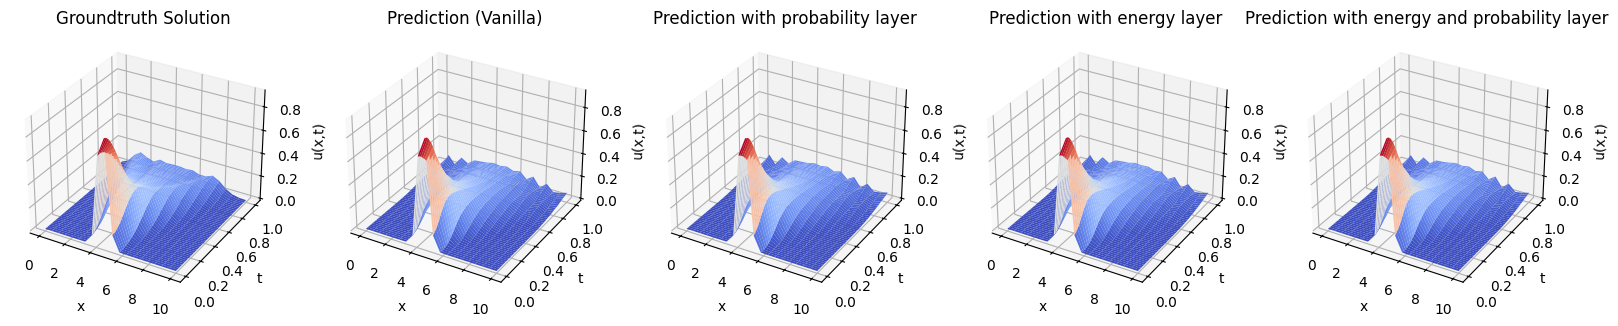

In [94]:
i = 0
x_grid, t_grid  = np.meshgrid(x, t)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, subplot_kw={'projection': '3d'},figsize=(20, 4))



# Plot predicted solution
ax1.plot_surface(x_grid, t_grid, np.abs(y_train_sol[i, :, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax1.set_title("Groundtruth Solution")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u(x,t)")


ax2.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax2.set_title("Prediction (Vanilla)")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u(x,t)")

ax3.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred_prob[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax3.set_title("Prediction with probability layer")
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_zlabel("u(x,t)")

ax4.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred_energy[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax4.set_title("Prediction with energy layer")
ax4.set_xlabel("x")
ax4.set_ylabel("t")
ax4.set_zlabel("u(x,t)")



ax5.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred_energy_prob[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax5.set_title("Prediction with energy and probability layer")
ax5.set_xlabel("x")
ax5.set_ylabel("t")
ax5.set_zlabel("u(x,t)")
plt.show()

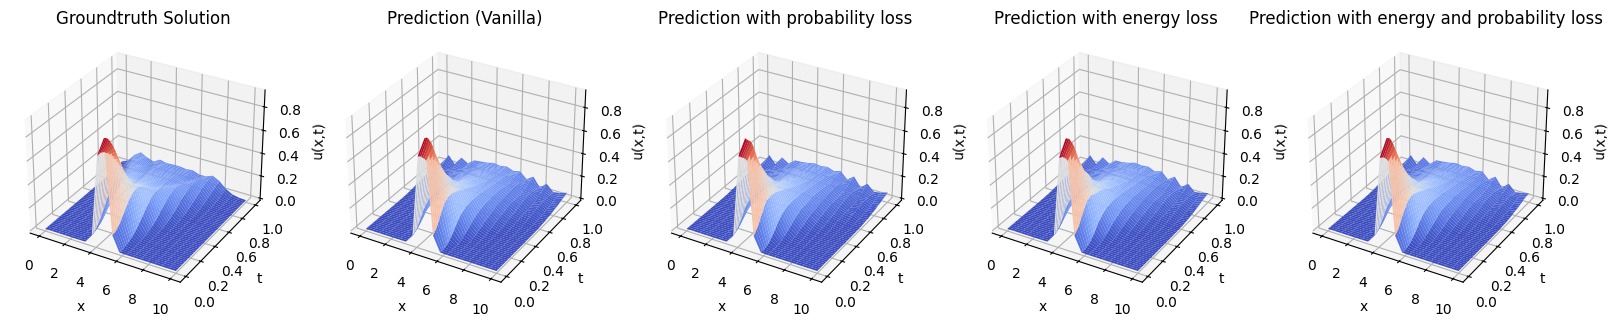

In [95]:
x_grid, t_grid  = np.meshgrid(x, t)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, subplot_kw={'projection': '3d'},figsize=(20, 4))



# Plot predicted solution
ax1.plot_surface(x_grid, t_grid, np.abs(y_train_sol[i, :, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax1.set_title("Groundtruth Solution")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u(x,t)")


ax2.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax2.set_title("Prediction (Vanilla)")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u(x,t)")

ax3.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred_PI[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax3.set_title("Prediction with probability loss")
ax3.set_xlabel("x")
ax3.set_ylabel("t")

ax3.set_zlabel("u(x,t)")

ax4.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred_EI[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax4.set_title("Prediction with energy loss")
ax4.set_xlabel("x")
ax4.set_ylabel("t")
ax4.set_zlabel("u(x,t)")



ax5.plot_surface(x_grid, t_grid, np.abs(y_train_sol_pred_EI_PI[i,:, :])**2, rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
ax5.set_title("Prediction with energy and probability loss")
ax5.set_xlabel("x")
ax5.set_ylabel("t")

ax5.set_zlabel("u(x,t)")
plt.show()

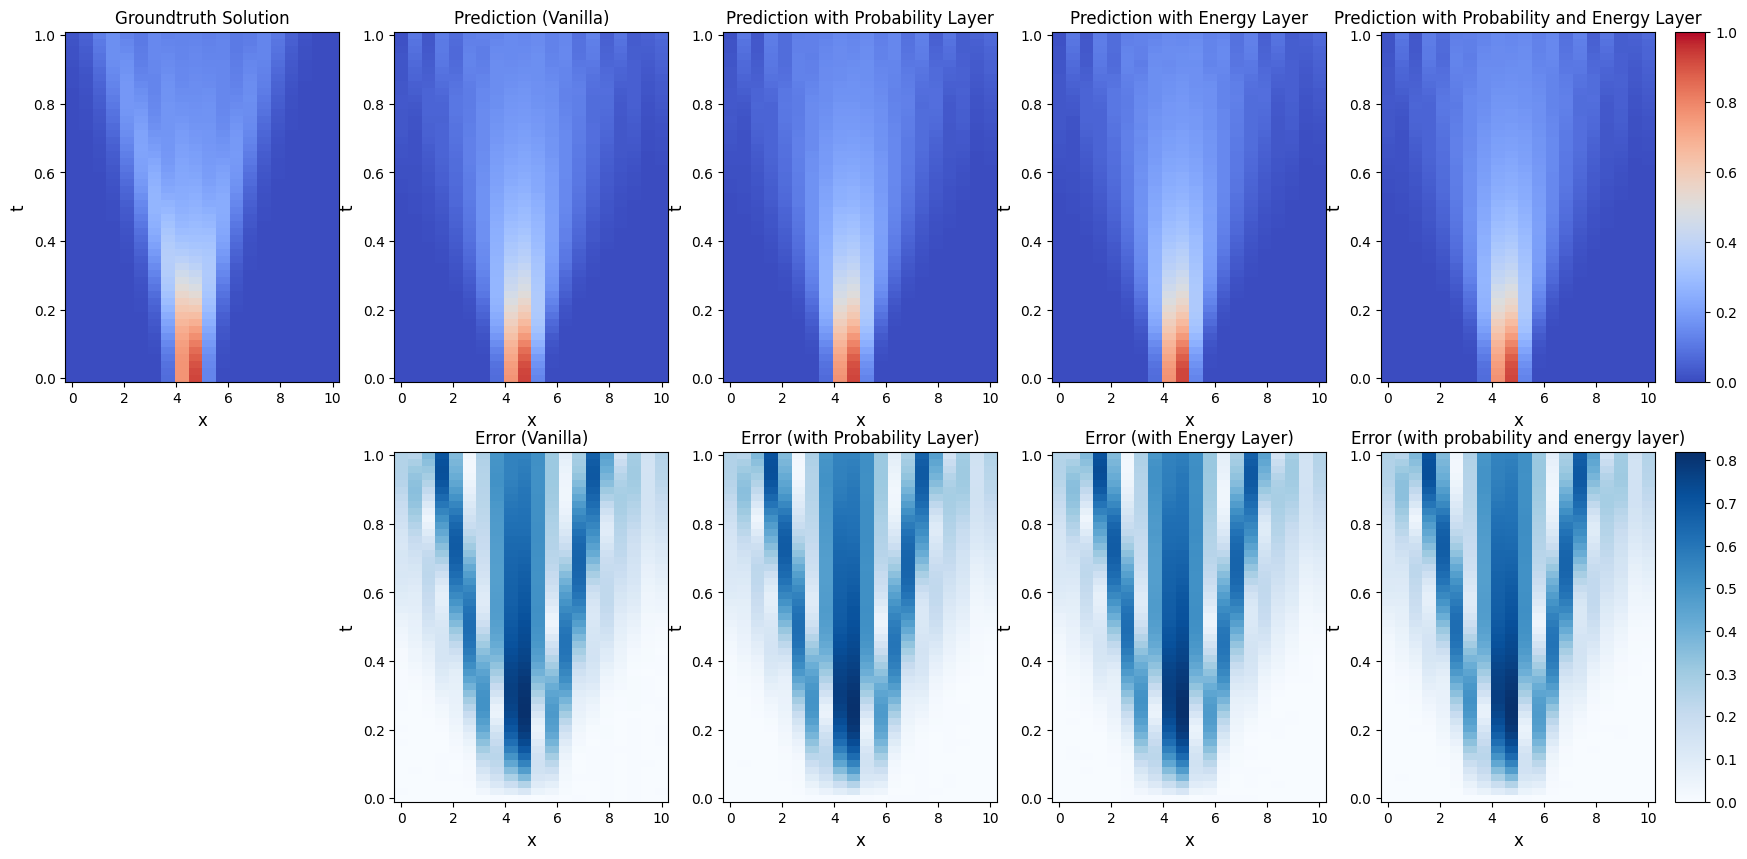

In [96]:
fontsize = 12
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
absmax = 1.0

pcm0 = axes[0, 0].pcolormesh(x_grid, t_grid, np.abs(y_train_sol[i])**2, shading='auto', cmap= cm.coolwarm, vmin= 0, vmax=absmax)
axes[0, 0].set_title("Groundtruth Solution", fontsize=fontsize)
axes[0, 0].set_xlabel("x", fontsize=fontsize)
axes[0, 0].set_ylabel("t", fontsize=fontsize)

pcm1 = axes[0, 1].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred[i])**2, shading='auto', cmap= cm.coolwarm, vmin= 0, vmax=absmax)
axes[0, 1].set_title("Prediction (Vanilla)", fontsize=fontsize)
axes[0, 1].set_xlabel("x", fontsize=fontsize)
axes[0, 1].set_ylabel("t", fontsize=fontsize)
 # optional: shows the color scale

pcm2 = axes[0, 2].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred_prob[i])**2, shading='auto', cmap= cm.coolwarm,  vmin= 0, vmax=absmax)
axes[0, 2].set_title("Prediction with Probability Layer", fontsize=fontsize)
axes[0, 2].set_xlabel("x", fontsize=fontsize)
axes[0, 2].set_ylabel("t", fontsize=fontsize)

pcm3 = axes[0, 3].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred_energy[i])**2, shading='auto', cmap= cm.coolwarm,  vmin= 0, vmax=absmax)
axes[0, 3].set_title("Prediction with Energy Layer", fontsize=fontsize)
axes[0, 3].set_xlabel("x", fontsize=fontsize)
axes[0, 3].set_ylabel("t", fontsize=fontsize)

pcm4 = axes[0, 4].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred_energy_prob[i])**2, shading='auto', cmap= cm.coolwarm,  vmin= 0, vmax=absmax)
axes[0, 4].set_title("Prediction with Probability and Energy Layer", fontsize=fontsize)
axes[0, 4].set_xlabel("x", fontsize=fontsize)
axes[0, 4].set_ylabel("t", fontsize=fontsize)
#fig.colorbar(pcm1, ax=axes[0, 0])
#fig.colorbar(pcm1, ax=axes[0, 1])
#fig.colorbar(pcm1, ax=axes[0, 2])
#fig.colorbar(pcm1, ax=axes[0, 3])
top_row_axes = axes[0, :]

# Place a standalone colorbar axis to the right of the top row


# Adjust the figure to make room for colorbar
fig.subplots_adjust(right=0.92)  # squashes nothing, just reserves space

# Add colorbar axis: [left, bottom, width, height]
cbar_ax_top = fig.add_axes([0.93, 0.53, 0.015, 0.35])  # adjust if needed

# Attach shared colorbar using any of the top-row pcms
fig.colorbar(pcm0, cax=cbar_ax_top)
axes[1, 0].axis('off')

error_multi = y_train_sol_pred[i] - y_train_sol[i]
error_energy = y_train_sol_pred_energy[i] - y_train_sol[i]
error_prob = y_train_sol_pred_prob[i] - y_train_sol[i]
error_energy_prob = y_train_sol_pred_energy_prob[i] - y_train_sol[i]
error_multi = y_train_sol_pred[i] - y_train_sol[i]
error_EI = y_train_sol_pred_EI[i] - y_train_sol[i]
error_PI = y_train_sol_pred_PI[i] - y_train_sol[i]
error_EI_PI = y_train_sol_pred_EI_PI[i] - y_train_sol[i]

absmax_err = max(
    np.max(np.abs(error_multi)),
    np.max(np.abs(error_energy)),
    np.max(np.abs(error_prob)),
    np.max(np.abs(error_energy_prob)),
    np.max(np.abs(error_EI)),
    np.max(np.abs(error_PI)),
    np.max(np.abs(error_EI_PI)),
)

#cmap_err = cm.bwr
cmap_err = 'Blues'
pcm5 = axes[1, 1].pcolormesh(x_grid, t_grid, np.abs(error_multi), shading='auto', cmap= cmap_err, vmin= 0 , vmax = absmax_err)
axes[1, 1].set_title("Error (Vanilla)", fontsize=fontsize)
axes[1, 1].set_xlabel("x", fontsize=fontsize)
axes[1, 1].set_ylabel("t", fontsize=fontsize)

pcm6 = axes[1, 2].pcolormesh(x_grid, t_grid,np.abs(error_prob), shading='auto', cmap= cmap_err, vmin= 0, vmax = absmax_err)
axes[1, 2].set_title("Error (with Probability Layer)", fontsize=fontsize)
axes[1, 2].set_xlabel("x", fontsize=fontsize)
axes[1, 2].set_ylabel("t", fontsize=fontsize)
#plt.savefig(f"C:\\Users\\zzh\\Desktop\\Oxford\\dissertation\\deeponet\\plots\\wave_pred_2d_{model.__name__}_net-{net.branch.linears[-1].out_features}-{net.trunk.linears[-1].out_features}_loss_fn-{loss_fn.__name__}_l2-{optimizer.param_groups[0]["weight_decay"]}")

pcm7 = axes[1, 3].pcolormesh(x_grid, t_grid, np.abs(error_energy), shading='auto', cmap= cmap_err, vmin=0, vmax = absmax_err)
axes[1, 3].set_title("Error (with Energy Layer)", fontsize=fontsize)
axes[1, 3].set_xlabel("x", fontsize=fontsize)
axes[1, 3].set_ylabel("t", fontsize=fontsize)


pcm8 = axes[1, 4].pcolormesh(x_grid, t_grid, np.abs(error_energy_prob), shading='auto', cmap= cmap_err, vmin=0, vmax = absmax_err)
axes[1, 4].set_title("Error (with probability and energy layer)", fontsize=fontsize)
axes[1, 4].set_xlabel("x", fontsize=fontsize)
axes[1, 4].set_ylabel("t", fontsize=fontsize)


bottom_row_axes = axes[1, :]
cbar_ax_bottom = fig.add_axes([0.93, 0.11, 0.015, 0.35])  # adjust if needed

# Attach shared colorbar using any of the top-row pcms
fig.colorbar(pcm6, cax=cbar_ax_bottom)

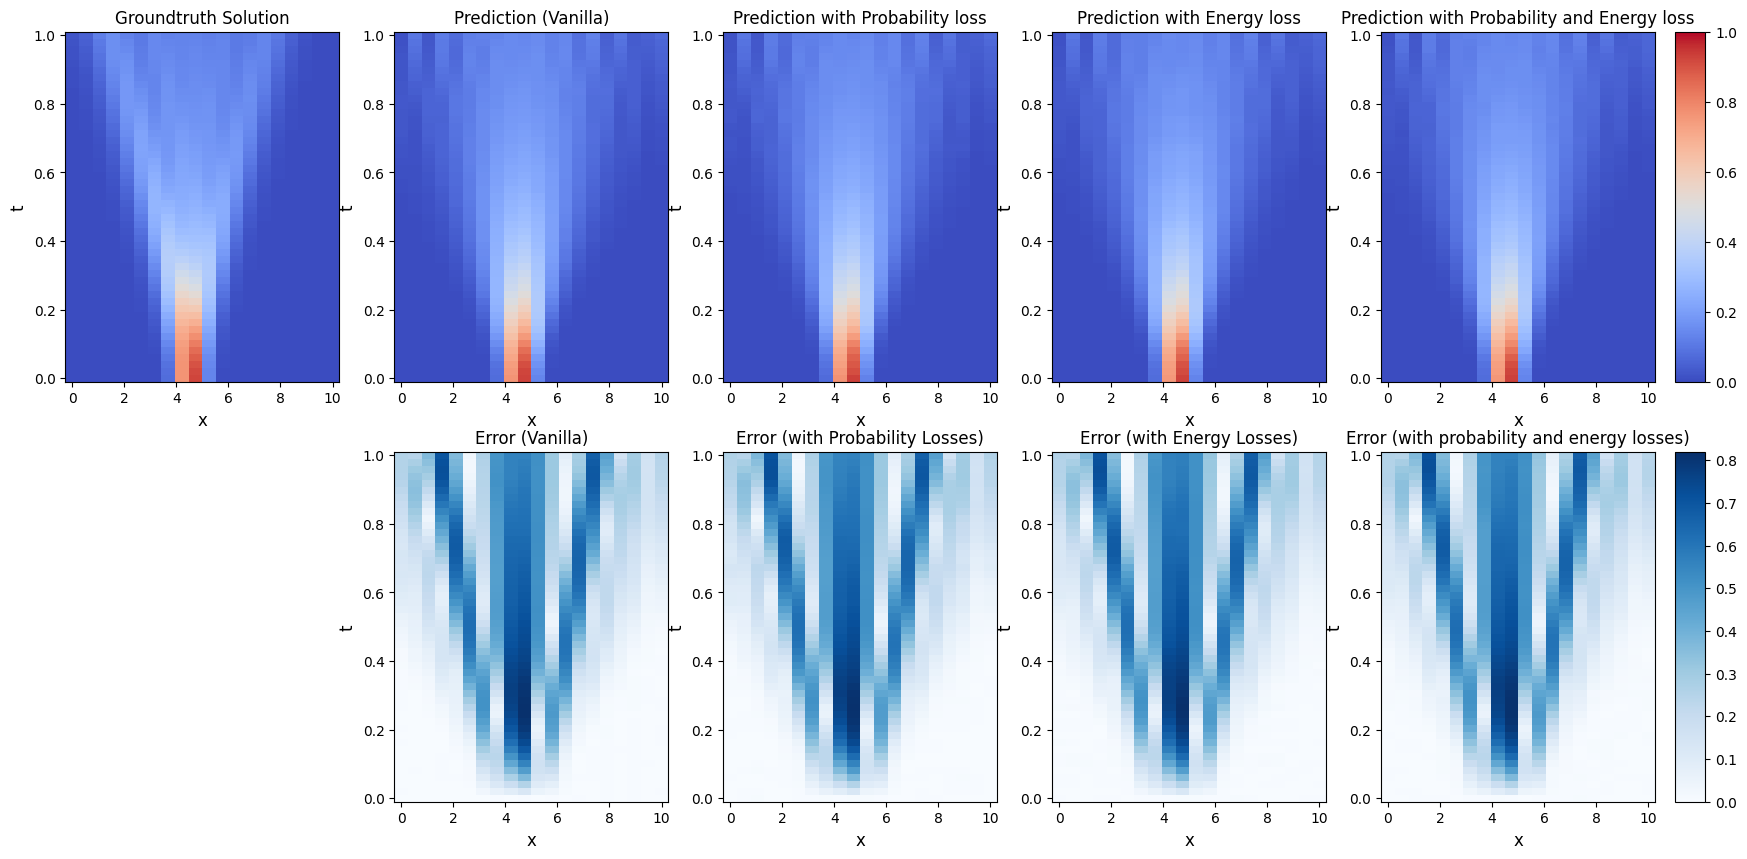

In [97]:
fontsize = 12
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
max_sol = np.max(y_train_sol[:, 0:nx].real)


min_sol= np.min(y_train_sol[:, 0:nx].real)

pcm0 = axes[0, 0].pcolormesh(x_grid, t_grid, np.abs(y_train_sol[i])**2, shading='auto', cmap= cm.coolwarm, vmin= 0, vmax=absmax)
axes[0, 0].set_title("Groundtruth Solution", fontsize=fontsize)
axes[0, 0].set_xlabel("x", fontsize=fontsize)
axes[0, 0].set_ylabel("t", fontsize=fontsize)

pcm1 = axes[0, 1].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred[i])**2, shading='auto', cmap= cm.coolwarm, vmin= 0, vmax=absmax)
axes[0, 1].set_title("Prediction (Vanilla)", fontsize=fontsize)
axes[0, 1].set_xlabel("x", fontsize=fontsize)
axes[0, 1].set_ylabel("t", fontsize=fontsize)
 # optional: shows the color scale

pcm2 = axes[0, 2].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred_PI[i])**2, shading='auto', cmap= cm.coolwarm,  vmin= 0, vmax=absmax)
axes[0, 2].set_title("Prediction with Probability loss", fontsize=fontsize)
axes[0, 2].set_xlabel("x", fontsize=fontsize)
axes[0, 2].set_ylabel("t", fontsize=fontsize)

pcm3 = axes[0, 3].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred_EI[i])**2, shading='auto', cmap= cm.coolwarm,  vmin= 0, vmax=absmax)
axes[0, 3].set_title("Prediction with Energy loss", fontsize=fontsize)
axes[0, 3].set_xlabel("x", fontsize=fontsize)
axes[0, 3].set_ylabel("t", fontsize=fontsize)

pcm4 = axes[0, 4].pcolormesh(x_grid, t_grid, np.abs(y_train_sol_pred_EI_PI[i])**2, shading='auto', cmap= cm.coolwarm,  vmin= 0,vmax=absmax)
axes[0, 4].set_title("Prediction with Probability and Energy loss", fontsize=fontsize)
axes[0, 4].set_xlabel("x", fontsize=fontsize)
axes[0, 4].set_ylabel("t", fontsize=fontsize)
#fig.colorbar(pcm1, ax=axes[0, 0])
#fig.colorbar(pcm1, ax=axes[0, 1])
#fig.colorbar(pcm1, ax=axes[0, 2])
#fig.colorbar(pcm1, ax=axes[0, 3])
top_row_axes = axes[0, :]

# Place a standalone colorbar axis to the right of the top row


# Adjust the figure to make room for colorbar
fig.subplots_adjust(right=0.92)  # squashes nothing, just reserves space

# Add colorbar axis: [left, bottom, width, height]
cbar_ax_top = fig.add_axes([0.93, 0.53, 0.015, 0.35])  # adjust if needed

# Attach shared colorbar using any of the top-row pcms
fig.colorbar(pcm0, cax=cbar_ax_top)
axes[1, 0].axis('off')

error_multi = y_train_sol_pred[i] - y_train_sol[i]
error_EI = y_train_sol_pred_EI[i] - y_train_sol[i]
error_PI = y_train_sol_pred_PI[i] - y_train_sol[i]
error_EI_PI = y_train_sol_pred_EI_PI[i] - y_train_sol[i]


#cmap_err = cm.bwr
cmap_err = 'Blues'
pcm5 = axes[1, 1].pcolormesh(x_grid, t_grid, np.abs(error_multi), shading='auto', cmap= cmap_err, vmin= 0 , vmax = absmax_err)
axes[1, 1].set_title("Error (Vanilla)", fontsize=fontsize)
axes[1, 1].set_xlabel("x", fontsize=fontsize)
axes[1, 1].set_ylabel("t", fontsize=fontsize)

pcm6 = axes[1, 2].pcolormesh(x_grid, t_grid,np.abs(error_PI), shading='auto', cmap= cmap_err, vmin= 0, vmax = absmax_err)
axes[1, 2].set_title("Error (with Probability Losses)", fontsize=fontsize)
axes[1, 2].set_xlabel("x", fontsize=fontsize)
axes[1, 2].set_ylabel("t", fontsize=fontsize)
#plt.savefig(f"C:\\Users\\zzh\\Desktop\\Oxford\\dissertation\\deeponet\\plots\\wave_pred_2d_{model.__name__}_net-{net.branch.linears[-1].out_features}-{net.trunk.linears[-1].out_features}_loss_fn-{loss_fn.__name__}_l2-{optimizer.param_groups[0]["weight_decay"]}")

pcm7 = axes[1, 3].pcolormesh(x_grid, t_grid, np.abs(error_EI), shading='auto', cmap= cmap_err, vmin=0, vmax = absmax_err)
axes[1, 3].set_title("Error (with Energy Losses)", fontsize=fontsize)
axes[1, 3].set_xlabel("x", fontsize=fontsize)
axes[1, 3].set_ylabel("t", fontsize=fontsize)


pcm8 = axes[1, 4].pcolormesh(x_grid, t_grid, np.abs(error_EI_PI), shading='auto', cmap= cmap_err, vmin=0, vmax = absmax_err)
axes[1, 4].set_title("Error (with probability and energy losses)", fontsize=fontsize)
axes[1, 4].set_xlabel("x", fontsize=fontsize)
axes[1, 4].set_ylabel("t", fontsize=fontsize)


bottom_row_axes = axes[1, :]
cbar_ax_bottom = fig.add_axes([0.93, 0.11, 0.015, 0.35])  # adjust if needed

# Attach shared colorbar using any of the top-row pcms
fig.colorbar(pcm6, cax=cbar_ax_bottom)

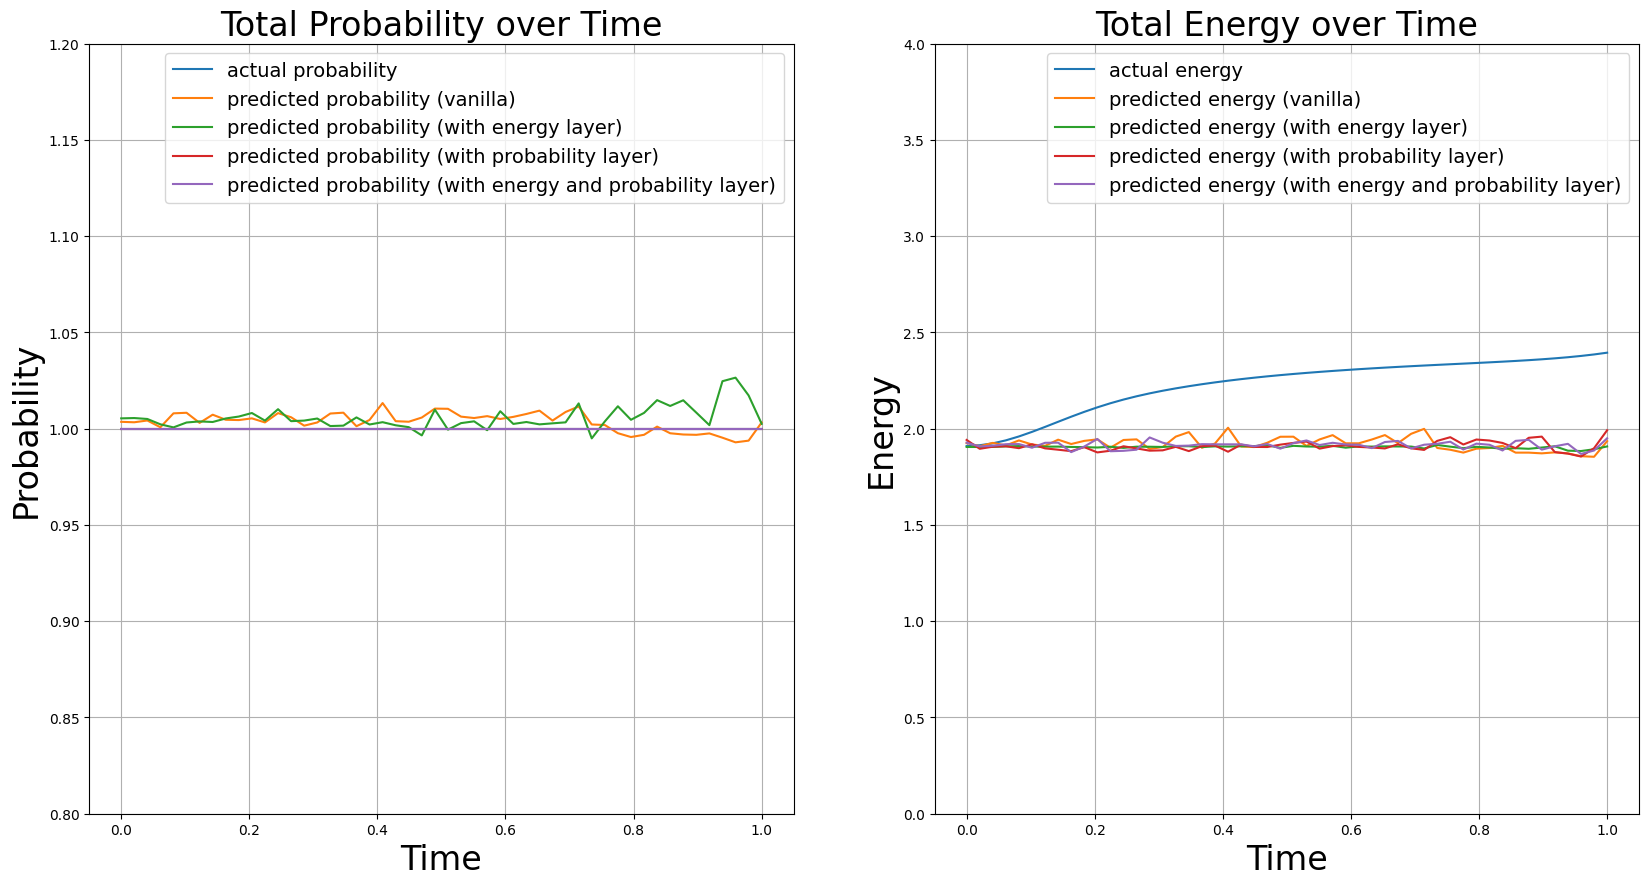

In [102]:

dx = L / (nx - 1)
k = 2 * np.pi * fftfreq(nx, dx)

W = dft(nx)
W_inv = W.conj().T / nx


# Construct differentiation matrix
D = np.diag(1j * k)


# Probability
prob_true = np.array([np.sum(np.abs(y)**2) for y in y_train_sol[i]]) * dx
prob_pred = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred[i]]) * dx
prob_pred_energy = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred_energy[i]]) *dx
prob_pred_prob = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred_prob[i]]) *dx
prob_pred_energy_prob = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred_energy_prob[i]]) * dx
prob_pred_EI = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred_EI[i]]) *dx
prob_pred_PI = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred_PI[i]]) *dx
prob_pred_EI_PI = np.array([np.sum(np.abs(y)**2) for y in y_train_sol_pred_EI_PI[i]]) *dx

y_train_x_sol = y_train[i]@D.T@W_inv.T
y_pred_x_sol = y_train_pred[i].numpy()@D.T@W_inv.T
y_pred_x_sol_energy = y_train_pred_energy[i].numpy()@D.T@W_inv.T
y_pred_x_sol_prob = y_train_pred_prob[i].numpy()@D.T@W_inv.T
y_pred_x_sol_energy_prob = y_train_pred_energy_prob[i].numpy()@D.T@W_inv.T
y_pred_x_sol_EI = y_train_pred_EI[i].numpy()@D.T@W_inv.T
y_pred_x_sol_PI = y_train_pred_PI[i].numpy()@D.T@W_inv.T
y_pred_x_sol_EI_PI = y_train_pred_EI_PI[i].numpy()@D.T@W_inv.T 




t = np.linspace(0, T, nt)   

#energy_true = dx*np.array([np.sum(np.abs(y_train_x_sol[0])**2)*0.5 + np.sum(np.abs(y_train_x_sol[0])**2) *0.5 ]* nt)
energy_true = dx*np.array([np.sum(np.abs(y_train_x_sol[i])**2)*0.5 + np.sum(np.abs(y_train_x_sol[i])**2) *0.5 for i in range(nt)])
energy_pred = dx*np.array([np.sum(np.abs(y_pred_x_sol[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol[i])**2) *0.5 for i in range(nt)])
energy_pred_energy = dx*np.array([np.sum(np.abs(y_pred_x_sol_energy[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol_energy[i])**2) *0.5 for i in range(nt)])
energy_pred_prob = dx*np.array([np.sum(np.abs(y_pred_x_sol_prob[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol_prob[i])**2) *0.5 for i in range(nt)])
energy_pred_energy_prob = dx*np.array([np.sum(np.abs(y_pred_x_sol_energy_prob[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol_energy_prob[i])**2) *0.5 for i in range(nt)])
energy_pred_EI = dx*np.array([np.sum(np.abs(y_pred_x_sol_EI[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol_EI[i])**2) *0.5 for i in range(nt)])
energy_pred_PI = dx*np.array([np.sum(np.abs(y_pred_x_sol_PI[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol_PI[i])**2) *0.5 for i in range(nt)])
energy_pred_EI_PI = dx*np.array([np.sum(np.abs(y_pred_x_sol_EI_PI[i])**2)*0.5 + np.sum(np.abs(y_pred_x_sol_EI_PI[i])**2) *0.5 for i in range(nt)])

# Plot predicted solution
#energy_max = max(np.max(np.abs(energy_true)), np.max(np.abs(energy_pred_mult)), np.max(np.abs(energy_pred_energy)), np.max(np.abs(energy_pred_SL)))
fontsize=24
fig , (axes) = plt.subplots(1, 2, figsize=(20, 10))  
axes[0].plot(t, prob_true, label='actual probability')
axes[0].plot(t, prob_pred, label='predicted probability (vanilla)')
axes[0].plot(t, prob_pred_energy, label='predicted probability (with energy layer)')
axes[0].plot(t, prob_pred_prob, label='predicted probability (with probability layer)')
axes[0].plot(t, prob_pred_energy_prob, label='predicted probability (with energy and probability layer)')
#axes[0].plot(t, prob_pred_EI, label='predicted probability (with energy loss)')
#axes[0].plot(t, prob_pred_PI, label='predicted probability (with probability loss)')
#axes[0].plot(t, prob_pred_EI_PI, label='predicted probability (with energy and probability loss)')
axes[0].grid(True)
axes[0].set_xlabel("Time", fontsize=fontsize)
axes[0].set_ylabel("Probability", fontsize=fontsize)
axes[0].set_ylim(0.8, 1.2)
axes[0].set_title("Total Probability over Time", fontsize=fontsize)
axes[0].legend(prop={'size': 14})

axes[1].plot(t, energy_true, label='actual energy')
axes[1].plot(t, energy_pred, label='predicted energy (vanilla)')
axes[1].plot(t, energy_pred_energy, label='predicted energy (with energy layer)')
axes[1].plot(t, energy_pred_prob, label='predicted energy (with probability layer)')
axes[1].plot(t, energy_pred_energy_prob, label='predicted energy (with energy and probability layer)')
#axes[1].plot(t, energy_pred_EI, label='predicted energy (with energy loss)')
#axes[1].plot(t, energy_pred_PI, label='predicted energy (with probability loss)')
#axes[1].plot(t, energy_pred_EI_PI, label='predicted energy (with energy and probability loss)')
axes[1].set_ylim(0.0, 4.0)
axes[1].grid(True)
axes[1].set_xlabel("Time", fontsize=fontsize)
axes[1].set_ylabel("Energy", fontsize=fontsize)
axes[1].set_title("Total Energy over Time", fontsize=fontsize)
axes[1].legend(prop ={'size': 14})

plt.show()

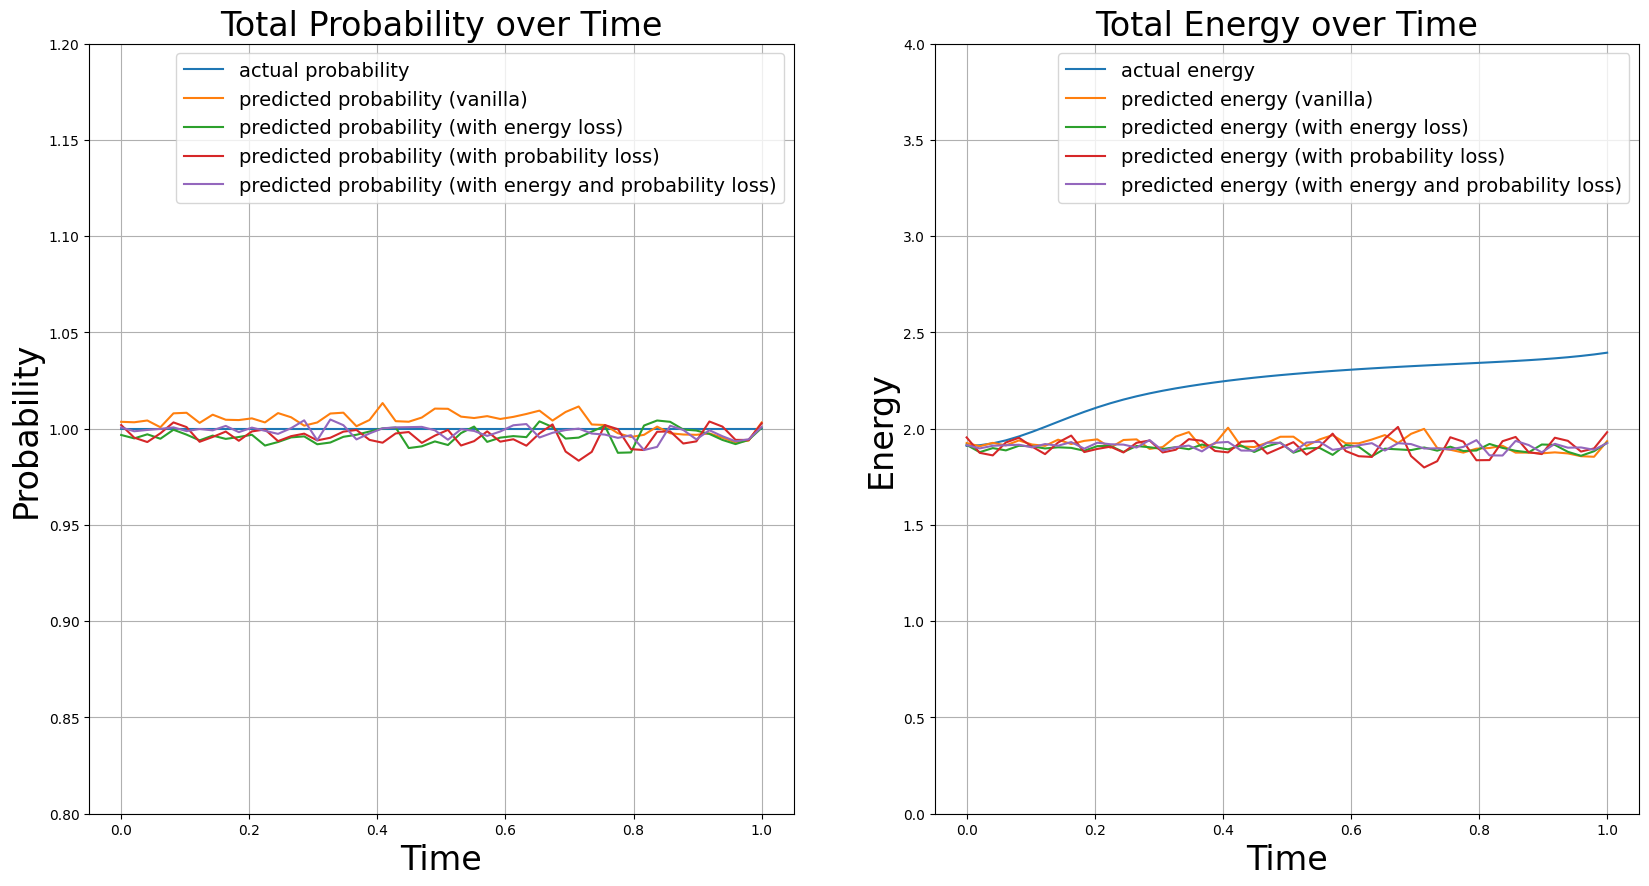

In [103]:
fontsize=24
fig , (axes) = plt.subplots(1, 2, figsize=(20, 10))  
axes[0].plot(t, prob_true, label='actual probability')
axes[0].plot(t, prob_pred, label='predicted probability (vanilla)')
#axes[0].plot(t, prob_pred_energy, label='predicted probability (with energy layer)')
#axes[0].plot(t, prob_pred_prob, label='predicted probability (with probability layer)')
#axes[0].plot(t, prob_pred_energy_prob, label='predicted probability (with energy and probability layer)')
axes[0].plot(t, prob_pred_EI, label='predicted probability (with energy loss)')
axes[0].plot(t, prob_pred_PI, label='predicted probability (with probability loss)')
axes[0].plot(t, prob_pred_EI_PI, label='predicted probability (with energy and probability loss)')
axes[0].grid(True)
axes[0].set_xlabel("Time", fontsize=fontsize)
axes[0].set_ylabel("Probability", fontsize=fontsize)
axes[0].set_ylim(0.8, 1.2)
axes[0].set_title("Total Probability over Time", fontsize=fontsize)
axes[0].legend(prop={'size': 14})

axes[1].plot(t, energy_true, label='actual energy')
axes[1].plot(t, energy_pred, label='predicted energy (vanilla)')
#axes[1].plot(t, energy_pred_energy, label='predicted energy (with energy layer)')
#axes[1].plot(t, energy_pred_prob, label='predicted energy (with probability layer)')
#axes[1].plot(t, energy_pred_energy_prob, label='predicted energy (with energy and probability layer)')
axes[1].plot(t, energy_pred_EI, label='predicted energy (with energy loss)')
axes[1].plot(t, energy_pred_PI, label='predicted energy (with probability loss)')
axes[1].plot(t, energy_pred_EI_PI, label='predicted energy (with energy and probability loss)')
axes[1].set_ylim(0.0, 4.0)
axes[1].grid(True)
axes[1].set_xlabel("Time", fontsize=fontsize)
axes[1].set_ylabel("Energy", fontsize=fontsize)
axes[1].set_title("Total Energy over Time", fontsize=fontsize)
axes[1].legend(prop ={'size': 14})
